# Курсовой проект

## Настройка окружения

In [51]:
import os
import socket
import datetime
import numpy as np
import pandas as pd
from collections import Counter

from pyspark.sql import SparkSession
from jinja2 import Environment, FileSystemLoader
from pyspark import StorageLevel, SparkConf, SparkContext, SQLContext
import pyspark.sql.types as T
import pyspark.sql.functions as F
from pyspark.sql.functions import udf, length, when, col, broadcast
from pyspark.sql.types import (
    BooleanType, 
    IntegerType, 
    LongType, 
    StringType, 
    ArrayType, 
    FloatType, 
    StructType, 
    StructField, 
    MapType,
    DateType
)

In [52]:
# setting constants
DATA_PATH = '/home/ktravin-335556/'
APP_NAME = "CUSTOM_APP"
NORMALIZED_APP_NAME = APP_NAME.replace('/', '_').replace(':', '_')

APPS_TMP_DIR = os.path.join(os.getcwd(), "tmp")
APPS_CONF_DIR = os.path.join(os.getcwd(), "conf")
APPS_LOGS_DIR = os.path.join(os.getcwd(), "logs")
LOG4J_PROP_FILE = os.path.join(APPS_CONF_DIR, "pyspark-log4j-{}.properties".format(NORMALIZED_APP_NAME))
LOG_FILE = os.path.join(APPS_LOGS_DIR, 'pyspark-{}.log'.format(NORMALIZED_APP_NAME))
EXTRA_JAVA_OPTIONS = "-Dlog4j.configuration=file://{} -Dspark.hadoop.dfs.replication=1 -Dhttps.protocols=TLSv1.0,TLSv1.1,TLSv1.2,TLSv1.3"\
    .format(LOG4J_PROP_FILE)

LOCAL_IP = socket.gethostbyname(socket.gethostname())

In [53]:
# preparing configuration files from templates
for directory in [APPS_CONF_DIR, APPS_LOGS_DIR, APPS_TMP_DIR]:
    if not os.path.exists(directory):
        os.makedirs(directory)

env = Environment(loader=FileSystemLoader('/opt'))
template = env.get_template("pyspark_log4j.properties.template")
template\
    .stream(logfile=LOG_FILE)\
    .dump(LOG4J_PROP_FILE)

In [54]:
# run spark
spark = SparkSession\
    .builder\
    .appName(APP_NAME)\
    .master("k8s://https://10.32.7.103:6443")\
    .config("spark.driver.host", LOCAL_IP)\
    .config("spark.ui.port", "4040")\
    .config("spark.kubernetes.memoryOverheadFactor", "0.6")\
    .config("spark.driver.memory", "4g")\
    .config("spark.driver.bindAddress", "0.0.0.0")\
    .config("spark.executor.instances", "5")\
    .config("spark.executor.cores", '4')\
    .config("spark.executor.memory", "5g")\
    .config("spark.memory.fraction", "0.6")\
    .config("spark.memory.storageFraction", "0.5")\
    .config("spark.sql.autoBroadcastJoinThreshold", "-1")\
    .config("spark.driver.extraJavaOptions", EXTRA_JAVA_OPTIONS)\
    .config("spark.kubernetes.namespace", "ktravin-335556")\
    .config("spark.kubernetes.driver.label.appname", APP_NAME)\
    .config("spark.kubernetes.executor.label.appname", APP_NAME)\
    .config("spark.kubernetes.container.image.pullPolicy", "Always")\
    .config("spark.kubernetes.container.image", "node03.st:5000/spark-executor:ktravin-335556")\
    .config("spark.kubernetes.executor.deleteOnTermination", "true")\
    .config("spark.local.dir", "/tmp/spark")\
    .getOrCreate()

In [55]:
print("Web UI: {}".format(spark.sparkContext.uiWebUrl))
print("\nlog4j file: {}".format(LOG4J_PROP_FILE))
print("\ndriver log file: {}".format(LOG_FILE))

Web UI: http://10.128.227.100:4040

log4j file: /home/jovyan/nfs-home/conf/pyspark-log4j-CUSTOM_APP.properties

driver log file: /home/jovyan/nfs-home/logs/pyspark-CUSTOM_APP.log


## Чтение и подготовка данных

### Чтение документов из json файлов

In [56]:
documents_df = spark.read.json([
    "hdfs:///home/ktravin-335556/China_COMP_documents.json",
    "hdfs:///home/ktravin-335556/Russian_Federation_COMP_documents.json",
])

In [57]:
documents_df.printSchema()

root
 |-- affiliation_city: string (nullable = true)
 |-- affiliation_country: string (nullable = true)
 |-- affilname: string (nullable = true)
 |-- afid: string (nullable = true)
 |-- aggregationType: string (nullable = true)
 |-- article_number: string (nullable = true)
 |-- authkeywords: string (nullable = true)
 |-- author_afids: string (nullable = true)
 |-- author_count: string (nullable = true)
 |-- author_ids: string (nullable = true)
 |-- author_names: string (nullable = true)
 |-- citedby_count: string (nullable = true)
 |-- coverDate: string (nullable = true)
 |-- coverDisplayDate: string (nullable = true)
 |-- creator: string (nullable = true)
 |-- description: string (nullable = true)
 |-- doi: string (nullable = true)
 |-- eIssn: string (nullable = true)
 |-- eid: string (nullable = true)
 |-- fund_acr: string (nullable = true)
 |-- fund_no: string (nullable = true)
 |-- fund_sponsor: string (nullable = true)
 |-- issn: string (nullable = true)
 |-- issueIdentifier: stri

### Чтение метрик журналов

In [81]:
journal_metrics = spark.read\
    .csv(
        'hdfs:///home/ktravin-335556/journal_metrics.csv', 
        header=True, 
        inferSchema=True
    )\
    .select(
        col('Scopus Source ID').name('source_id'), 
        col('Percentile').cast(IntegerType()), 
        'Quartile'
    )

### Чтение кластеризованных тематик публикаций

In [82]:
document_topics = spark.read.csv(
    'hdfs:///home/ktravin-335556/labeled_dataset.csv', 
    header=True, 
    inferSchema=True
)

### Дополнение фрейма с документами новыми данными

In [83]:
documents_df = documents_df.join(journal_metrics, on=["source_id"], how="left_outer")
documents_df = documents_df.na.fill(value=0, subset=["Percentile", "Quartile"])

In [85]:
documents_df = documents_df.join(document_topics, on=["eid"], how="left_outer")
documents_df = documents_df.na.fill(value=-1, subset=["topic"])

In [90]:
prepared_df = documents_df\
  .withColumn('affiliation_city', F.split(col('affiliation_city'), ';'))\
  .withColumn('affiliation_country', F.split(col('affiliation_country'), ';'))\
  .withColumn('affilname', F.split(col('affilname'), ';'))\
  .withColumn('afid', F.split(col('afid'), ';'))\
  .withColumn('author_afids', F.split(col('author_afids'), ';'))\
  .withColumn('author_ids', F.split(col('author_ids'), ';'))\
  .withColumn('author_names', F.split(col('author_names'), ';'))\
  .withColumn("author_count", col('author_count').cast(IntegerType()))\
  .withColumn("citedby_count", col('citedby_count').cast(IntegerType()))\
  .withColumn("openaccess", col('openaccess').cast(IntegerType()))\
  .withColumnRenamed('Percentile', 'percentile')\
  .withColumnRenamed('Quartile', 'quartile')

In [91]:
prepared_df.printSchema()

root
 |-- eid: string (nullable = true)
 |-- source_id: string (nullable = true)
 |-- affiliation_city: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- affiliation_country: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- affilname: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- afid: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- aggregationType: string (nullable = true)
 |-- article_number: string (nullable = true)
 |-- authkeywords: string (nullable = true)
 |-- author_afids: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- author_count: integer (nullable = true)
 |-- author_ids: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- author_names: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- citedby_count: integer (nullable = true)
 |-- coverDate: string (nullable = true)
 |-- coverDispl

### Создание фрейма с авторами

In [93]:
array_mean = udf(lambda x: float(round(np.mean(x), 0)), FloatType())

udf_flatten_counter = udf(
  lambda x: dict(Counter(x)),
  MapType(StringType(), IntegerType())
)

udf_choose_most_popular_item = udf(
  lambda x: 'Unknown' if not len(x) else sorted(
    dict(Counter(x)).items(),
    key = lambda x: x[1],
    reverse=True
  )[0][0],
  StringType()
)

In [94]:
author_df = prepared_df\
  .withColumn("author_id", F.explode(prepared_df.author_ids))\
  .select('eid', 'topic', 'percentile', 'affiliation_country', 'aggregationType', 'subtypeDescription', 'author_count', 'citedby_count', 'openaccess', 'author_id')\
  .groupBy("author_id")\
  .agg(
      F.collect_list("eid").name('document_eids'),
      F.size(F.collect_list("eid")).name('document_count'), 
      F.flatten(F.collect_list("affiliation_country")).name("affiliation_countries"),
      udf_choose_most_popular_item(udf_flatten_counter(F.collect_list("topic"))).name('preferTopic'),
      udf_choose_most_popular_item(udf_flatten_counter(F.flatten(F.collect_list("affiliation_country")))).name("preferAffiliationCountry"),
      udf_choose_most_popular_item(udf_flatten_counter(F.collect_list("aggregationType"))).name('preferAggregationType'),
      udf_choose_most_popular_item(udf_flatten_counter(F.collect_list("subtypeDescription"))).name('preferSubtypeDescription'),
      udf_choose_most_popular_item(udf_flatten_counter(F.collect_list("openaccess"))).name('preferAccess'),
      array_mean(F.collect_list("author_count")).name('meanAuthorCounts'),
      array_mean(F.collect_list("percentile")).name('meanPercentile'),
      array_mean(F.collect_list("citedby_count")).name('meanCitedbyCounts')
  )\
  .where(col("preferAggregationType") != 'Unknown')\
  .where(col("preferTopic") != -1)\
  .sort(col('document_count').desc())

In [95]:
author_df.printSchema()

root
 |-- author_id: string (nullable = true)
 |-- document_eids: array (nullable = false)
 |    |-- element: string (containsNull = false)
 |-- document_count: integer (nullable = false)
 |-- affiliation_countries: array (nullable = false)
 |    |-- element: string (containsNull = true)
 |-- preferTopic: string (nullable = true)
 |-- preferAffiliationCountry: string (nullable = true)
 |-- preferAggregationType: string (nullable = true)
 |-- preferSubtypeDescription: string (nullable = true)
 |-- preferAccess: string (nullable = true)
 |-- meanAuthorCounts: float (nullable = true)
 |-- meanPercentile: float (nullable = true)
 |-- meanCitedbyCounts: float (nullable = true)



### Подготовка признаков

Можно воспользоваться инсрументом Pipeline, чтобы объединить все классы, преобразующие данные в одну модель

In [97]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import (
    StringIndexer, 
    OneHotEncoder, 
    VectorAssembler, 
    StandardScaler, 
    PCA
)

indexer = StringIndexer(
  inputCols=["preferTopic", "preferAccess", "preferAggregationType", "preferSubtypeDescription"], 
  outputCols=["preferTopicNumeric", "preferAccessNumeric", "preferAggregationTypeNumeric", "preferSubtypeDescriptionNumeric"]
)

encoder = OneHotEncoder(
    inputCols=["preferTopicNumeric", "preferAccessNumeric", "preferAggregationTypeNumeric", "preferSubtypeDescriptionNumeric"], 
    outputCols=["preferTopicVector", "preferAccessVector", "preferAggregationTypeVector", "preferSubtypeDescriptionVector"]
)

assembler = VectorAssembler(
  inputCols=[
    'preferAggregationTypeVector',
    'preferSubtypeDescriptionVector',
    'preferAccessVector',
    'preferTopicVector',
    'meanAuthorCounts',
    'meanPercentile',
    'meanCitedbyCounts',
  ], outputCol='features'
)

scaler = StandardScaler(inputCol='features', outputCol='standardized_features')

pca = PCA(k=2, inputCol="standardized_features", outputCol="pca_features")

pipeline = Pipeline(stages=[
           indexer,
           encoder,
           assembler,
           scaler,
           pca,
])

transform_model = pipeline.fit(author_df)
transformed_author_df = transform_model.transform(author_df)
transformed_author_df.show(2)

+-----------+--------------------+--------------+---------------------+-----------+------------------------+---------------------+------------------------+------------+----------------+--------------+-----------------+------------------+-------------------+----------------------------+-------------------------------+-----------------+------------------+---------------------------+------------------------------+--------------------+---------------------+--------------------+
|  author_id|       document_eids|document_count|affiliation_countries|preferTopic|preferAffiliationCountry|preferAggregationType|preferSubtypeDescription|preferAccess|meanAuthorCounts|meanPercentile|meanCitedbyCounts|preferTopicNumeric|preferAccessNumeric|preferAggregationTypeNumeric|preferSubtypeDescriptionNumeric|preferTopicVector|preferAccessVector|preferAggregationTypeVector|preferSubtypeDescriptionVector|            features|standardized_features|        pca_features|
+-----------+--------------------+--------

## Кластеризация

### Подбор параметров

In [23]:
from tqdm.notebook import tqdm
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

silhouette_score = []
evaluator = ClusteringEvaluator(
    predictionCol='prediction', featuresCol='standardized_features', \
    metricName='silhouette', distanceMeasure='squaredEuclidean'
)

for i in tqdm(range(10, 40, 3)):
    KMeans_algo = KMeans(featuresCol='standardized_features', k=i)
    KMeans_fit = KMeans_algo.fit(transformed_author_df)
    
    output = KMeans_fit.transform(transformed_author_df)
    score = evaluator.evaluate(output)
    silhouette_score.append(score)
    
    print("Silhouette Score:", score)

  0%|          | 0/10 [00:00<?, ?it/s]

Silhouette Score: 0.23708986366797424
Silhouette Score: 0.22929894337742868
Silhouette Score: 0.45062881469741917
Silhouette Score: 0.41342943819721295
Silhouette Score: 0.56014514477171
Silhouette Score: 0.5516361964376904
Silhouette Score: 0.7301804831345151
Silhouette Score: 0.6991793407986253
Silhouette Score: 0.6948116852821147
Silhouette Score: 0.8202290753804145


In [24]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,1, figsize =(8,6))

ax.plot(range(10, 40, 3),silhouette_score)
ax.set_xlabel("k")
ax.set_ylabel("cost")

Text(0, 0.5, 'cost')

### Обучение модели

In [26]:
kmeans = KMeans().setK(37).setSeed(42).setFeaturesCol("standardized_features")
model = kmeans.fit(transformed_author_df)

In [27]:
# Make predictions
predictions = model.transform(transformed_author_df)

In [28]:
# Show up the centers.
centers = model.clusterCenters()
print("Cluster Centers: ")
for center in centers[:2]:
    print(center)

Cluster Centers: 
[6.61340516e-04 2.40363631e-04 2.78973467e+00 0.00000000e+00
 2.02916553e+00 5.06827848e-02 1.62732709e-01 0.00000000e+00
 7.96879807e-04 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 2.80026169e+00
 2.05196403e+00 5.11233088e-03 2.77111312e-03 1.88159493e-02
 2.72866481e-02 1.02176417e-02 3.48795497e-03 0.00000000e+00
 0.00000000e+00 0.00000000e+00 3.55240670e-01 6.89135947e-01
 6.27068762e-02]
[ 0.          2.19211631  0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.         89.93373695  1.51884759  1.08537068  0.
  1.41582923  0.          0.          0.          0.          0.
  0.          0.          0.57684433  2.85548494  8.73087504]


### Визуализация данных

In [29]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

In [30]:
colors = list(mcolors.CSS4_COLORS.values())

In [31]:
visualization_data = predictions.select("pca_features", "prediction").toPandas()

In [32]:
visualization_data[['x1','x2']] = pd.DataFrame(list(map(lambda x: (x[0], x[1]), visualization_data.pca_features.tolist())))

In [33]:
X = visualization_data[['x1', 'x2']].to_numpy()
y = visualization_data.prediction.to_numpy()

labels = np.unique(y)

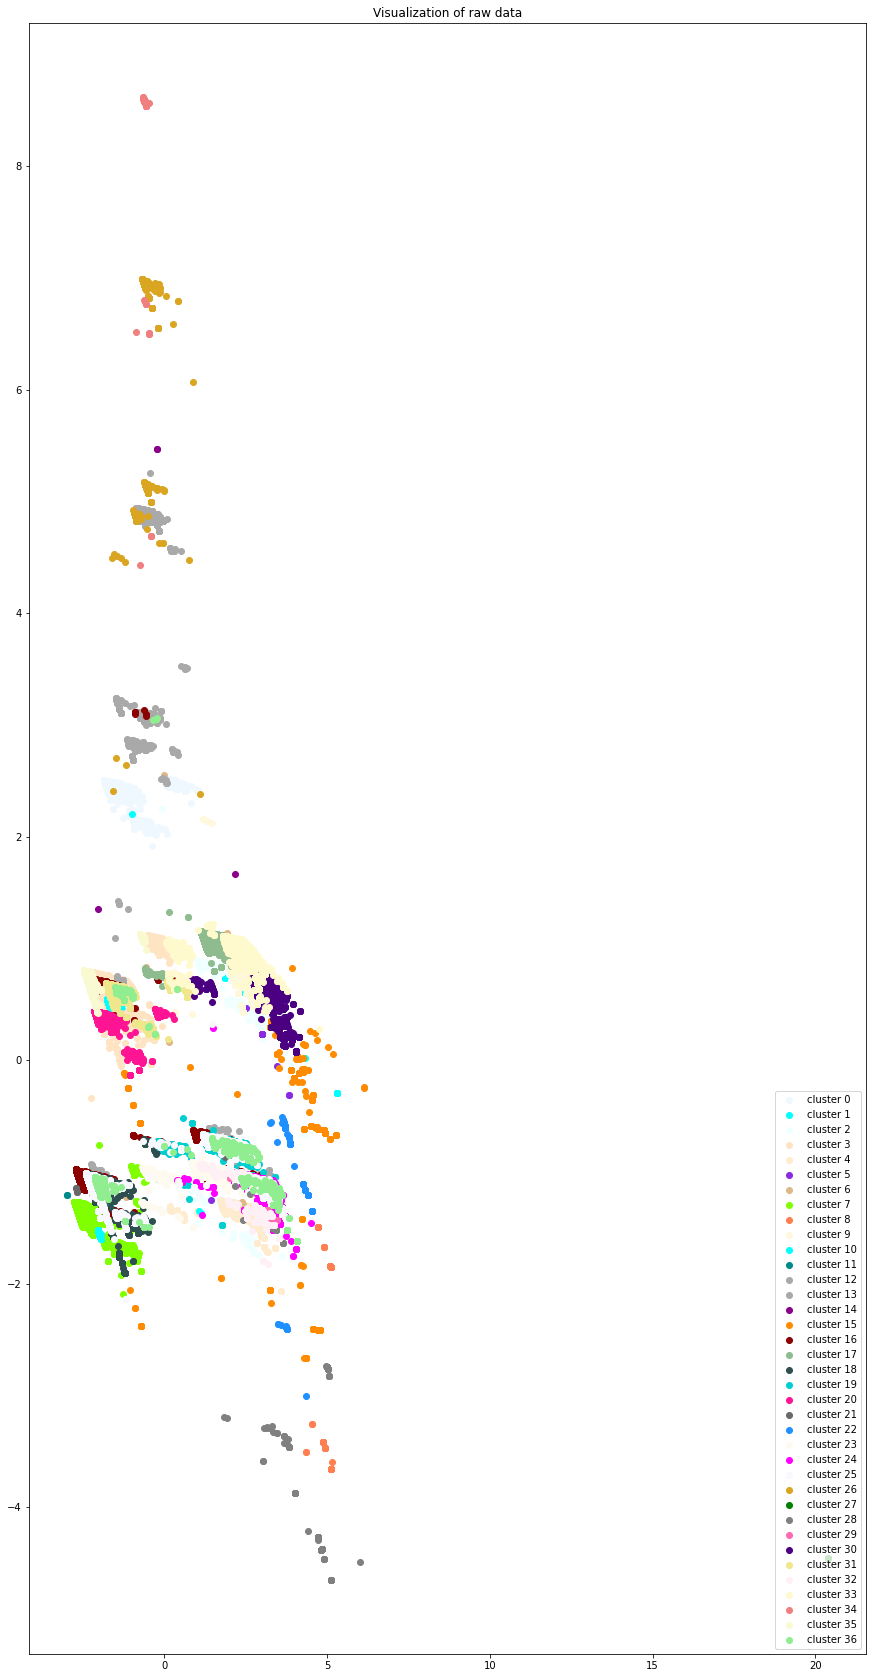

In [34]:
fig, ax = plt.subplots(figsize=(15,30))


for cluster in labels:
    color = colors[::2][cluster]
    plt.scatter(X[y == cluster][:,0], X[y == cluster][:,1], c=color, label=f'cluster {cluster}')

plt.legend(loc="lower right")
plt.title('Visualization of raw data');

## Сохранение моделей и размеченного датасета

In [28]:
kmeans_path = DATA_PATH + "/kmeans_model"
model.save(kmeans_path)

In [32]:
transform_path = DATA_PATH + "/transform_model"
transform_model.save(transform_path)

In [50]:
dataset_path = DATA_PATH + '/dataset_with_predictions.json'
predictions.write.format('json').save(dataset_path)

In [ ]:
spark.stop()